In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


#  Load the Dataset

In [2]:
train_df = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')
valid_df = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Valid.csv')
test_df  = pd.read_csv('/kaggle/input/imdb-dataset-sentiment-analysis-in-csv-format/Test.csv')

print("Train DataFrame shape:", train_df.shape)
print("Valid DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

Train DataFrame shape: (5000, 2)
Valid DataFrame shape: (5000, 2)
Test DataFrame shape: (5000, 2)


# Explore the Dataset

Train Data Sample:
                                                text  label
0  I always wrote this series off as being a comp...      0
1  1st watched 12/7/2002 - 3 out of 10(Dir-Steve ...      0
2  This movie was so poorly written and directed ...      0
3  The most interesting thing about Miryang (Secr...      1
4  when i first read about "berlin am meer" i did...      0

Review Length Statistics in Train Data:
count    5000.000000
mean      231.922800
std       174.525522
min        10.000000
25%       128.000000
50%       173.000000
75%       278.000000
max      2108.000000
Name: review_length, dtype: float64


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


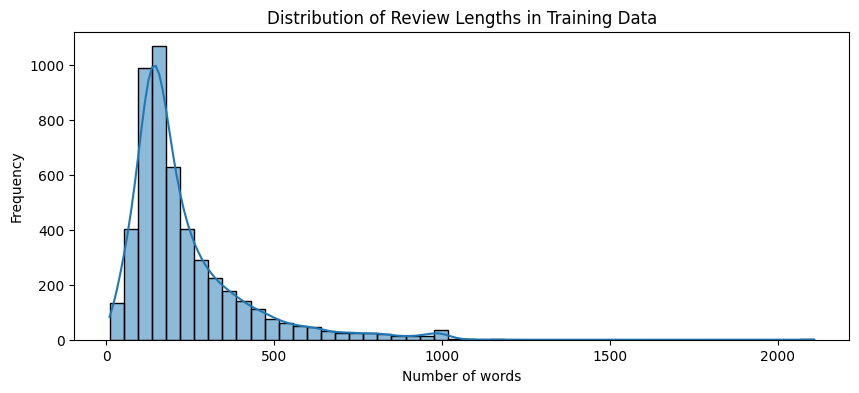


Label Distribution in Train Data:
label
1    2505
0    2495
Name: count, dtype: int64


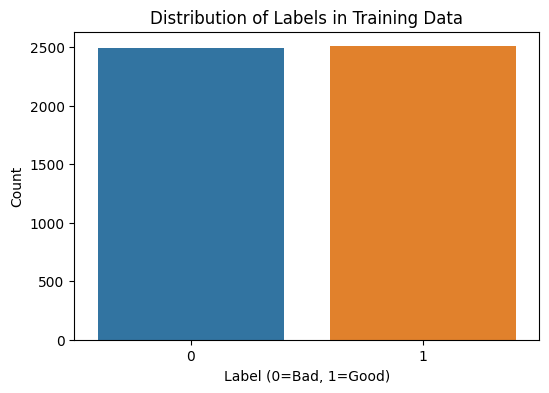

In [3]:
# Show a few rows of the training data
print("Train Data Sample:")
print(train_df.head())

# Check basic statistics for text lengths
train_df['review_length'] = train_df['text'].apply(lambda x: len(x.split()))
print("\nReview Length Statistics in Train Data:")
print(train_df['review_length'].describe())

# Plot the distribution of review lengths
plt.figure(figsize=(10, 4))
sns.histplot(train_df['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths in Training Data")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

# Check the label distribution
print("\nLabel Distribution in Train Data:")
print(train_df['label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df)
plt.title("Distribution of Labels in Training Data")
plt.xlabel("Label (0=Bad, 1=Good)")
plt.ylabel("Count")
plt.show()


# Preprocess the Data and Tokenization

In [4]:
# Extract text and labels directly
X_train = train_df['text']
y_train = train_df['label']

X_valid = valid_df['text']
y_valid = valid_df['label']

X_test = test_df['text']
y_test = test_df['label']


In [5]:
# Set parameters for tokenization and padding
max_vocab = 10000   # maximum vocabulary size
max_length = 200    # maximum review length (in words)

tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
valid_sequences = tokenizer.texts_to_sequences(X_valid)
test_sequences  = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
X_valid_padded = pad_sequences(valid_sequences, maxlen=max_length, padding='post', truncating='post')
X_test_padded  = pad_sequences(test_sequences,  maxlen=max_length, padding='post', truncating='post')


# Build the RNN Model

In [6]:
embedding_dim = 64  # Dimension for the embedding vector

model = Sequential([
    Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Train the Model

In [7]:
epochs = 10
batch_size = 128

history = model.fit(
    X_train_padded, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_valid_padded, y_valid)
)


Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.5117 - loss: 0.6940 - val_accuracy: 0.5070 - val_loss: 0.6938
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - accuracy: 0.5261 - loss: 0.6926 - val_accuracy: 0.5218 - val_loss: 0.6925
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 13s 326ms/step - accuracy: 0.5796 - loss: 0.6875 - val_accuracy: 0.5284 - val_loss: 0.6880
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - accuracy: 0.6175 - loss: 0.6488 - val_accuracy: 0.5512 - val_loss: 0.6801
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.6737 - loss: 0.5949 - val_accuracy: 0.5270 - val_loss: 0.7036
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.6398 - loss: 0.5933 - val_accuracy: 0.5894 - val_loss: 0.6854
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step - accuracy: 0.6989 - loss: 0.5213 - val_accuracy: 0.5926 - val_loss: 0.6897
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - accuracy: 0.7547 - loss: 0.4457 - val_accu

# Evaluate the Model

In [8]:
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.8536 - loss: 0.3368
Test Accuracy: 0.8490


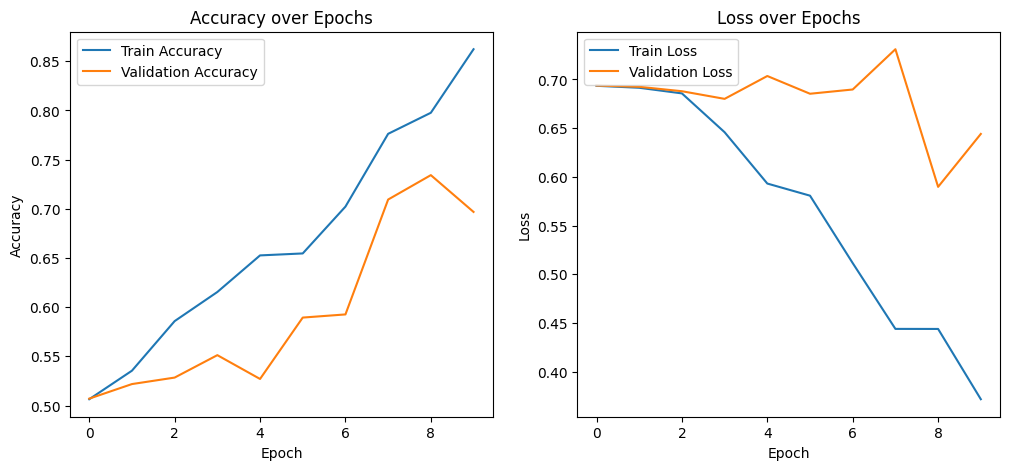

In [9]:
plt.figure(figsize=(12,5))

# Plot accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

# Plot loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

plt.show()


In [17]:

user_review = "It wasn't the best movie"

# Preprocess the review: tokenize and pad the sequence
review_sequence = tokenizer.texts_to_sequences([user_review])
review_padded = pad_sequences(review_sequence, maxlen=max_length, padding='post', truncating='post')

# Make a prediction using the trained model
prediction = model.predict(review_padded)
predicted_prob = prediction[0][0]

if predicted_prob >= 0.5:
    sentiment = "Positive"
    confidence = predicted_prob
else:
    sentiment = "Negative"
    confidence = 1 - predicted_prob
print("Review:")
print(user_review)
print("\nPredicted Sentiment:", sentiment, f"(Confidence: {confidence:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
this is the prediction 0.27603364
Review:
It wasn't the best movie

Predicted Sentiment: Negative (Confidence: 0.7240)
